In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from keras.models import load_model
from pathlib import Path

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T
from ml_tb.testing import get_PT_map, get_PT_analyses, get_ref_PT_analyses, PT_median, PT_error, T_error

In [2]:
# define the custom metrics
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

In [3]:
model = load_model(Path("..","03_transfer_learning", "saved_models", "03a_BtThermobarometer_finetuning"), compile=False)
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[RMSE_T, RMSE_P])
# model.summary()

# Plot test dataset

In [4]:
map_files =  ["Aiyana_GrtZone_550_3500.hdf5", "Aiyana_StZone_560_3500.hdf5", "Aiyana_AndZone_580_3500.hdf5", "Aiyana_SilZone_600_3500.hdf5", "Aiyana_KfsZone_650_3500.hdf5",
              "Cioffi2001_589_3800.hdf5", "JuliaArami_700_8000.hdf5", "Lanari_Hermann_2021_Map1.hdf5", "Lanari_Hermann_2021_Map2.hdf5", "LanariDuesterhoeft2019_790_6400.hdf5",
              "LanariDuesterhoeft2020_660_7000.hdf5", "Piccoli2022_620_10000.hdf5", "XenolithElOro_750_2000.hdf5"]

test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe", "Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil",
                "Kluane_Migmatite", "Kluane_Grt", "GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1",
                "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2",
                "GDB Hop Brook 2", "Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161",
                "Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
                "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

PT_ref = []
# add in reference PT manually, for the Maps
PT_ref_maps = [[3500, 550], [3500, 560], [3500, 580], [3500, 600], [3500, 650],
               [3800, 589], [8000, 700], [9000, 620], [9000, 620], [6400, 790],
               [7000, 660], [10000, 620], [2000, 750]]
for PT in PT_ref_maps:
    PT_ref.append(PT)

PT_predictions = []
PT_errors = []

for map_file in map_files:
    PT_map = get_PT_map(Path("..", "05b_maps", "XMapTools_map_files") / map_file, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_map))
    PT_errors.append(PT_error(PT_map))

for test_id in test_samples:
    PT_multi_analyses = get_PT_analyses(test_data_file, test_id, model, inv_scaling_pt)
    PT_predictions.append(PT_median(PT_multi_analyses))
    PT_errors.append(PT_error(PT_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

PT_predictions = np.array(PT_predictions)
PT_errors = np.array(PT_errors)

PT_ref = np.array(PT_ref)

In [5]:
rmse_T = np.sqrt(np.mean(np.square(PT_ref[:, 1] - PT_predictions[:, 1])))
rmse_P = np.sqrt(np.mean(np.square(PT_ref[:, 0] - PT_predictions[:, 0])))

print("RMSE T [C] {0:.2f}".format(rmse_T))
print("RMSE P [bar] {0:.2f}".format(rmse_P))

RMSE T [C] 44.88
RMSE P [bar] 3712.52


In [6]:
mae_T = np.mean(abs(PT_ref[:, 1] - PT_predictions[:, 1]))
mae_P = np.mean(abs(PT_ref[:, 0] - PT_predictions[:, 0]))

print("MAE T [C] {0:.2f}".format(mae_T))
print("MAE P [bar] {0:.2f}".format(mae_P))

MAE T [C] 33.50
MAE P [bar] 2822.28


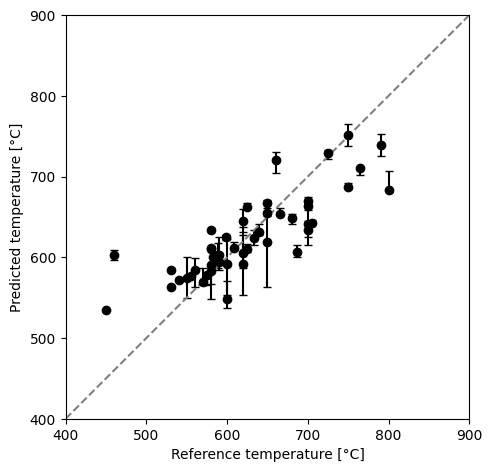

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.errorbar(PT_ref[:, 1], PT_predictions[:, 1], yerr=PT_errors[:, 1, 0].T, fmt="None", capsize=3, color="black")

ax.scatter(PT_ref[:, 1], PT_predictions[:, 1], marker="o", c="black", zorder=3)

ax.plot([400, 900], [400, 900], "--", color="gray")

ax.set_xlabel("Reference temperature [°C]")
ax.set_ylabel("Predicted temperature [°C]")
ax.set_xlim([400, 900])
ax.set_ylim([400, 900])
ax.set_aspect("equal")

fig.tight_layout()

# Compare with Ti-in-Biotite predictions

Ti-in-Biotite thermometers:
- Henry et al. (2005)
- Wu and Chen (2015)

In [8]:
from ml_tb.mapping import load_biotite_map
from ml_tb.testing import get_T_map_Henry05, get_T_map_Wu15, get_T_Henry05_analyses, get_T_Wu15_analysis

In [9]:
map_files =  ["Aiyana_GrtZone_550_3500.hdf5", "Aiyana_StZone_560_3500.hdf5", "Aiyana_AndZone_580_3500.hdf5", "Aiyana_SilZone_600_3500.hdf5", "Aiyana_KfsZone_650_3500.hdf5",
              "Cioffi2001_589_3800.hdf5", "JuliaArami_700_8000.hdf5", "Lanari_Hermann_2021_Map1.hdf5", "Lanari_Hermann_2021_Map2.hdf5", "LanariDuesterhoeft2019_790_6400.hdf5",
              "LanariDuesterhoeft2020_660_7000.hdf5", "Piccoli2022_620_10000.hdf5", "XenolithElOro_750_2000.hdf5"]

test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe", "Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil",
                "Kluane_Migmatite", "Kluane_Grt", "GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1",
                "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2",
                "GDB Hop Brook 2", "Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161",
                "Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
                "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

PT_ref = []
# add in reference PT manually, for the Maps
PT_ref_maps = [[3500, 550], [3500, 560], [3500, 580], [3500, 600], [3500, 650],
               [3800, 589], [8000, 700], [9000, 620], [9000, 620], [6400, 790],
               [7000, 660], [10000, 620], [2000, 750]]
for PT in PT_ref_maps:
    PT_ref.append(PT)

T_predictions_Henry05 = []
T_errors_Henry05 = []

for map_file in map_files:
    T_map = get_T_map_Henry05(Path("..", "05b_maps", "XMapTools_map_files") / map_file)
    T_predictions_Henry05.append(np.median(T_map))
    T_errors_Henry05.append(T_error(T_map))

for test_id in test_samples:
    T_multi_analyses = get_T_Henry05_analyses(test_data_file, test_id)
    T_predictions_Henry05.append(np.median(T_multi_analyses))
    T_errors_Henry05.append(T_error(T_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

T_predictions_Henry05 = np.array(T_predictions_Henry05)
T_errors_Henry05 = np.array(T_errors_Henry05)

PT_ref = np.array(PT_ref)

/Users/philip/Research/PhDProjectUNIL/0X_MLthermobarometry/transfer_learning_biotite_thermobarometry/src/ml_tb/mapping.py:147: RuntimeWarning: invalid value encountered in power
  temperature = ((np.log(Ti)-a-(c*(X_Mg**3)))/b)**0.333


In [10]:
rmse_T = np.sqrt(np.mean(np.square(PT_ref[:, 1] - T_predictions_Henry05)))
print("RMSE T [C] {0:.2f}".format(rmse_T))

RMSE T [C] 39.50


In [11]:
mae_T = np.mean(abs(PT_ref[:, 1] - T_predictions_Henry05))

print("MAE T [C] {0:.2f}".format(mae_T))

MAE T [C] 29.06


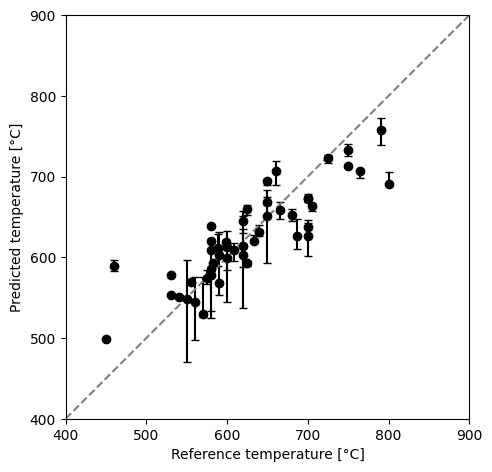

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.errorbar(PT_ref[:, 1], T_predictions_Henry05, yerr=T_errors_Henry05[:,0, 0].T, fmt="None", capsize=3, color="black")
ax.scatter(PT_ref[:, 1], T_predictions_Henry05, marker="o", c="black", zorder=3)

ax.plot([400, 900], [400, 900], "--", color="gray")

ax.set_xlabel("Reference temperature [°C]")
ax.set_ylabel("Predicted temperature [°C]")
ax.set_xlim([400, 900])
ax.set_ylim([400, 900])
ax.set_aspect("equal")


fig.tight_layout()

In [13]:
map_files =  ["Aiyana_GrtZone_550_3500.hdf5", "Aiyana_StZone_560_3500.hdf5", "Aiyana_AndZone_580_3500.hdf5", "Aiyana_SilZone_600_3500.hdf5", "Aiyana_KfsZone_650_3500.hdf5",
              "Cioffi2001_589_3800.hdf5", "JuliaArami_700_8000.hdf5", "Lanari_Hermann_2021_Map1.hdf5", "Lanari_Hermann_2021_Map2.hdf5", "LanariDuesterhoeft2019_790_6400.hdf5",
              "LanariDuesterhoeft2020_660_7000.hdf5", "Piccoli2022_620_10000.hdf5", "XenolithElOro_750_2000.hdf5"]

test_data_file = Path("test_data_metapelitic_biotite.xlsx")
test_samples = ["Vedrette de Ries", "South Tibetian Detachment", "Longmen Shan 13-4 Core", "Longmen Shan 13-4 Rim", "Longmen Shan 13-7 Core",
                "Longmen Shan 13-7 Rim", "Seve Nappe", "Kluane_Cord_1", "Kluane_Cord_2", "Kluane_AndSil",
                "Kluane_Migmatite", "Kluane_Grt", "GDB Hop Brook 1", "GDB Waterbury", "GDB Straits Schist 1",
                "GDB Taine Mountain 1", "GDB Collinsville", "GDB Straits Schist 2", "GDB Straits Schist 3", "GDB Taine Mountain 2",
                "GDB Hop Brook 2", "Leech river AG080", "Leech river AG042", "Leech river AG067", "Leech river AG1161",
                "Suru Valley Grt Zone 1", "Suru Valley Grt Zone 2", "Suru Valley Stau Zone 1", "Suru Valley Stau Zone 2", "Suru Valley Ky Zone 1",
                "Suru Valley Ky Zone 2", "Suru Valley Sil Zone 1", "Suru Valley Sil Zone 2", "Suru Valley Kfs Zone 1", "Suru Valley Kfs Zone 2"]

PT_ref = []
# add in reference PT manually, for the Maps
PT_ref_maps = [[3500, 550], [3500, 560], [3500, 580], [3500, 600], [3500, 650],
               [3800, 589], [8000, 700], [9000, 620], [9000, 620], [6400, 790],
               [7000, 660], [10000, 620], [2000, 750]]
for PT in PT_ref_maps:
    PT_ref.append(PT)

T_predictions_Wu15 = []
T_errors_Wu15 = []

for i, map_file in enumerate(map_files):
    T_map = get_T_map_Wu15(Path("..", "05b_maps", "XMapTools_map_files") / map_file, PT_ref_maps[i][0] / 10000)
    T_predictions_Wu15.append(np.median(T_map))
    T_errors_Wu15.append(T_error(T_map))

for test_id in test_samples:
    P_ref = get_ref_PT_analyses(test_data_file, test_id)[0]

    T_multi_analyses = get_T_Wu15_analysis(test_data_file, test_id, P_ref / 10000)
    T_predictions_Wu15.append(np.median(T_multi_analyses))
    T_errors_Wu15.append(T_error(T_multi_analyses))

    # add ref PT
    PT_ref.append(get_ref_PT_analyses(test_data_file, test_id))

T_predictions_Wu15 = np.array(T_predictions_Wu15)
T_errors_Wu15 = np.array(T_errors_Wu15)

PT_ref = np.array(PT_ref)

Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0
Al(VI) < 0, set to 0


In [14]:
rmse_T = np.sqrt(np.mean(np.square(PT_ref[:, 1] - T_predictions_Wu15)))
print("RMSE T [C] {0:.2f}".format(rmse_T))

RMSE T [C] 46.98


In [15]:
mae_T = np.mean(abs(PT_ref[:, 1] - T_predictions_Wu15))

print("MAE T [C] {0:.2f}".format(mae_T))

MAE T [C] 35.48


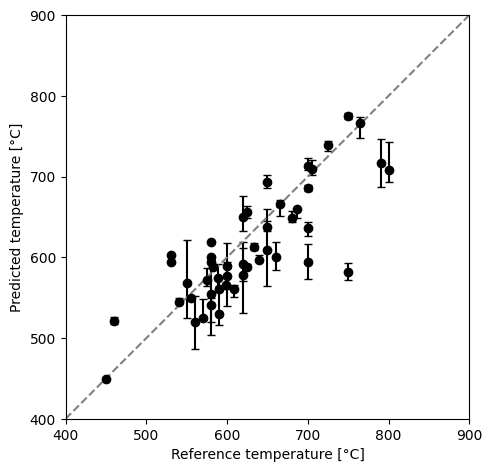

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.errorbar(PT_ref[:, 1], T_predictions_Wu15, yerr=T_errors_Wu15[:,0, 0].T, fmt="None", capsize=3, color="black")
ax.scatter(PT_ref[:, 1], T_predictions_Wu15, marker="o", c="black", zorder=3)

ax.plot([400, 900], [400, 900], "--", color="gray")

ax.set_xlabel("Reference temperature [°C]")
ax.set_ylabel("Predicted temperature [°C]")
ax.set_xlim([400, 900])
ax.set_ylim([400, 900])
ax.set_aspect("equal")


fig.tight_layout()

# Combined plot

In [17]:
PT_ref[:, 1] - T_predictions_Wu15

array([-18.65576223,  40.03815438,  26.1022106 ,  23.71881275,
        40.90404349,  14.96569592, 105.27855087,  28.86003532,
        42.01039073,  73.62520403,  59.40238022, -30.18092436,
       167.91761669, -20.38977447,   0.97053569, -73.22544759,
       -39.11441471, -63.76271436, -13.94783985,  10.63553933,
       -43.72855205,  12.41269704,  29.69551108, -13.47580265,
       -61.38026499,  91.54407768,  -1.13729261,  31.25312926,
        37.26541635,  27.57482835,  14.54316199,  64.11479349,
       -31.32796285, -24.66309077,  60.31856112,  44.92400314,
         5.68805964,  38.70868186,   2.86824395,  -3.19280283,
        33.45358595,  48.2171705 ,  -6.31371454,  20.49036214,
        -1.22308737,  42.55051634, -13.01713041,  -4.42254261])

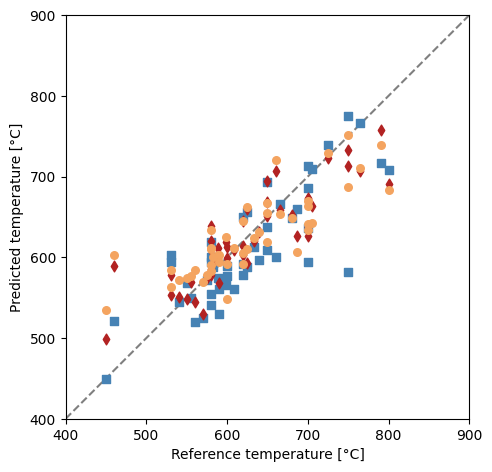

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(PT_ref[:, 1], T_predictions_Wu15, marker="s", s=30, c="steelblue", zorder=3)
ax.scatter(PT_ref[:, 1], T_predictions_Henry05, marker="d", s=30, c="firebrick", zorder=4)
ax.scatter(PT_ref[:, 1], PT_predictions[:, 1], marker="o", s=30, c="sandybrown", zorder=5)

ax.plot([400, 900], [400, 900], "--", color="gray")

ax.set_xlabel("Reference temperature [°C]")
ax.set_ylabel("Predicted temperature [°C]")
ax.set_xlim([400, 900])
ax.set_ylim([400, 900])
ax.set_aspect("equal")

fig.tight_layout()
# fig.savefig(Path("exported_figs", "Comparison_T_with_Ti_in_Bt.pdf"), dpi=600)

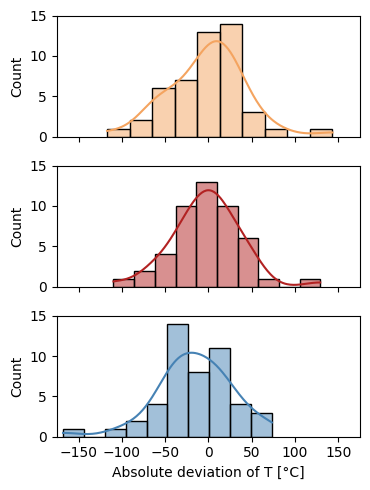

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(3.8, 5), sharex=True)

sns.histplot(PT_predictions[:, 1] - PT_ref[:, 1], bins=10, color="sandybrown", ax=axs[0], kde=True)
sns.histplot(T_predictions_Henry05 - PT_ref[:, 1], bins=10, color="firebrick", ax=axs[1], kde=True)
sns.histplot(T_predictions_Wu15- PT_ref[:, 1], bins=10, color="steelblue", ax=axs[2], kde=True)

axs[0].set_ylim([0, 15])
axs[1].set_ylim([0, 15])
axs[2].set_ylim([0, 15])

axs[2].set_xlim([-175, 175])
axs[2].set_xlabel("Absolute deviation of T [°C]")

fig.tight_layout()
# fig.savefig(Path("exported_figs", "Comparison_T_with_Ti_in_Bt_hist.pdf"), dpi=600)